In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import snntorch as snn
from snntorch import utils
from snntorch import spikegen
import snntorch.spikeplot as splt
from snntorch import surrogate
from snntorch import functional

import tonic
from IPython.display import HTML

import matplotlib.pyplot as plt
import numpy as np

#for profiling
%%load_ext heat

In [3]:
temporal_filters = 6
downsample_size = (64,64)
slice_meta_path = "./tmp/DVS_sliced/"

dtype=torch.float
torch.manual_seed(734)
print("Convolutional SNN Trained on DVS Gesture")

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Training Parameters
batch_size=16 #TODO 256 might cause OOM but its whats used in the paper
data_path='./tmp/data/DVS'
num_classes = 11  # DVS has 10 output classes, one for out of class

filter_delay = 16


transform1 = tonic.transforms.Compose([ tonic.transforms.Downsample(sensor_size=(128,128),target_size=downsample_size), tonic.transforms.ToFrame(sensor_size=(*downsample_size,2),n_time_bins=96)]) #for some reason using time_window results in sometimes getting 95 frames

#try using a timesurface and getting rid of temporal layer - creating the stacked frames uses way too much memory and this seems like a good alternative
transform2 =  tonic.transforms.Compose([ tonic.transforms.Downsample(sensor_size=(128,128),target_size=downsample_size), tonic.transforms.ToTimesurface(sensor_size=(*downsample_size,2),dt=1000,tau=16000) ])

#downsample to stay consistent with paper + helps save memory

train_dvs = tonic.datasets.DVSGesture(data_path,train=True)
test_dvs = tonic.datasets.DVSGesture(data_path,train=False)
#TODO consider using  DiskCachedDataset for performance
slicer = tonic.slicers.SliceByTime(96000,80000,False) #for some reason, it gives me one less frame than i need, hence 97=>96+1 (000)
#allow an overlap such that we start a new slice at every 16ms - each frame in a 16ms window will be presented to feature i during training, but only once. if you want multiple exposure just use multiple epochs
 
#TODO careful , you will need to regenerate after changing parameters, however without it takes about 30 seconds to generate the slices
#slice our dataset - we do not need the entire dataset at once
train_sliced_dvs = tonic.SlicedDataset(train_dvs,slicer=slicer,transform=transform1, metadata_path=slice_meta_path+"train/")
test_sliced_dvs = tonic.SlicedDataset(test_dvs,slicer=slicer,transform=transform1, metadata_path=slice_meta_path+"test/")

train_loader = DataLoader(train_sliced_dvs, batch_size=batch_size, shuffle=True,drop_last=False)
test_loader = DataLoader(test_sliced_dvs, batch_size=batch_size, shuffle=True,drop_last=False)


#time step is 1000 microseconds i.e. 1ms


Convolutional SNN Trained on DVS Gesture
Using device: cuda
Metadata written to ./tmp/DVS_sliced/train/slice_metadata.h5.
Metadata written to ./tmp/DVS_sliced/test/slice_metadata.h5.


In [6]:
print(a[0].shape)

torch.Size([16, 96, 2, 64, 64])


training samples:  428601
testing samples:  110639


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Right arm ccw
torch.Size([16, 96, 2, 64, 64])


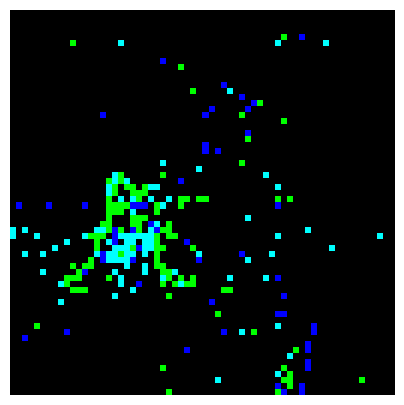

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


training samples:  428601
testing samples:  110639


In [12]:
print("training samples: ",len(train_sliced_dvs))
print("testing samples: ",len(test_sliced_dvs))
#if you want to create more samples you can change the overlap (but you might cause overfitting)

a = next(iter(test_loader))
print(test_dvs.classes[a[1][0]])
print(a[0].shape)
b = torch.zeros((temporal_filters,2,*downsample_size))
for i in range(temporal_filters):
    b[i] = torch.sum( a[0][0][i*filter_delay:((i+1)*filter_delay)] , dim=0 )
animation = tonic.utils.plot_animation(frames=b)
display(HTML(animation.to_jshtml()))
#the frames themselves dont look too well like a gesture but remember we are accumulating all these frames
#the last (6th) filter starts at the 80'th frame and runs up to the 95th after 16 timesteps

#these are the 6 images that each filter sees over the timeteps - can see it gives us a (rough) video clip of the gesture that is (somewhat) recognisable (some of them are pretty dubious but i think thats due to different lighting used)

print("training samples: ",len(train_sliced_dvs)) #~500,000
print("testing samples: ",len(test_sliced_dvs)) #~100,000

In [13]:


################ DVS Gesture Model #############################

# (without temporal layer - this is up for interpretation)

# layer parameters
num_steps = 16  # assuming 16 steps as we use 16ms filter window, chip runs at 1ms; can also get decent accuracy using 16 timesteps on spiking MNIST
beta = 1 /32
lr=20
#weight_decay=1e-6

spike_grad1 = surrogate.atan()


def temporal_filter(data,step):
    #fetches the frames at the i'th timestep

    #data should be shape [batch_size, 96, 2, 128, 128]
    batch_size = data.shape[0]

    cascade_frames = torch.zeros((batch_size,temporal_filters, 2, *downsample_size),device=device )

    if (len(data.shape) == 5): #  assume batched data
        for i in range(temporal_filters):
            dt = step + (i * filter_delay) #newest frames are at the last axis element, however the model doesnt care about direction of our frames - they are still sequential w.r.t. to time
            if dt<0: raise ValueError("sample length not long enough time window to create temporal filter input.")
            else:
                cascade_frames[:,i,:,:,:] = data[:,dt,:,:,:]
    else:
        raise ValueError("data is incorrect size (to be batched) - shape: ",data.shape)
    
    return cascade_frames.reshape((batch_size,temporal_filters*2,*downsample_size))


class Net(nn.Module):

    def __init__(self):
        super().__init__()

        self.loss = functional.ce_count_loss()
        self.accuracy_metric = functional.accuracy_rate

        #initialise neuron connections
        #from table 1 in DVS paper
        #TODO im multiplying features by two as paper states 6 input features, but we have seperate channels for increase/decrease events
        self.layers = nn.ModuleList([
            #64x64
            nn.Conv2d(6*2,12*2,3,2,0,1,1),
            nn.Conv2d(12*2,252*2,4,2,0,1,2),
            nn.Conv2d(252*2,256*2,1,1,0,1,2),
            nn.Conv2d(256*2,256*2,2,2,0,1,2),
            nn.Conv2d(256*2,512*2,3,1,1,1,32),
            nn.Conv2d(512*2,512*2,1,1,0,1,4),
            nn.Conv2d(512*2,512*2,1,1,0,1,4),
            nn.Conv2d(512*2,512*2,1,1,0,1,4),
            nn.Conv2d(512*2,512*2,2,2,0,1,16),
            nn.Conv2d(512*2,1024*2,3,1,1,1,64),
            nn.Conv2d(1024*2,1024*2,1,1,0,1,8), #typo in table here
            nn.Conv2d(1024*2,1024*2,1,1,0,1,8),
            nn.Conv2d(1024*2,1024*2,2,2,0,1,32),
            nn.Conv2d(1024*2,1024*2,1,1,0,1,8),
            nn.Conv2d(1024*2,968*2,1,1,0,1,8),
            nn.Conv2d(968*2,2640*2,1,1,0,1,8),
            #need additional layer to pool features into output classes
            #pooling1d? conv1d#
            nn.AvgPool1d(int(5280 / 11)),
        ])

        # initialize neurons
        self.neurons = nn.ModuleList(
            [snn.Leaky(beta=beta,spike_grad=spike_grad1)] * 16
        )


        #pytorch creates the tensors to represent the network layout and weights for each layer; snntorch provides the model that operates on the entire tensor (at each layer).

  
    def forward(self,x): #x is input data
        #events should be treated as spikes i.e. already encoded

        # Initialize hidden states
        mem = []
        for i in range(16):
            mem.append(self.neurons[i].init_leaky())
        
        # record spike outputs
        spk_rec = []

        for step in range(num_steps):
            #form inputs
            spk_i = temporal_filter(x,step).to(device)

            for i in range(16):
                cur_i = self.layers[i](spk_i)
                spk_i, mem[i] = self.neurons[i](cur_i,mem[i])

            #special case for maxpool1d
            spk_i = spk_i.view(batch_size,1,2640*2)
            spk_i = self.layers[16](spk_i)
            spk_rec.append(spk_i.view(batch_size,11))

        return torch.stack(spk_rec, dim=0) #TODO do i really need to return membrane potentials
    
###################################################################################



In [14]:
a = next(iter(test_loader))
print(a[0].shape)
print(temporal_filter(a[0],3).shape)

net = Net().to(device)
net.train()
r = net.forward(a[0].to(device))
print("r: ",r.shape)
print(torch.max(r))

torch.Size([16, 96, 2, 64, 64])
torch.Size([16, 12, 64, 64])
r:  torch.Size([16, 16, 11])
tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)


In [15]:
########### STATS ##############

def print_stats(data, targets):
    output = net(data)
    acc  = net.accuracy_metric(output, targets)
    #dev = np.std((targets == idx).detach().cpu().numpy()) #TODO deviation for latency encoding
    print(f"    Accuracy: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {img_counter}, Minibatch stats:")
    print(f"    Train Set Loss: {loss_hist[batch_counter]:.2f}")
    print(f"    Test Set Loss: {test_loss_hist[img_counter]:.2f}")
    print_stats(test_data, test_targets)
    print("Train batch: ")
    print_stats(data, targets)
    print("\n")


##############################


# Load the network onto CUDA
net = Net().to(device)
optimiser = torch.optim.Adam(net.parameters(),lr=lr)

num_epochs = 1
loss_hist = []
test_loss_hist = []

img_counter = 0 #total no. of images iterated over

#training loop
for epoch in range(num_epochs):
    batch_counter=0 #image number within current batch

    #mini-batch loop
    for data, targets in iter(train_loader):

        data = data.float().to(device)
        targets = targets.to(device)

        # forward pass
        net.train() #inform pytorch
        spk_rec = net(data)

        #calculate loss as cross entropy of membrane potential at each step
        loss_val = net.loss(spk_rec,targets)

        
        optimiser.zero_grad() #(reset for batch)
        loss_val.backward() #calculate backpropogation error gradient
        optimiser.step() #then update parameters

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad(): #tell pytorch to disable gradient calculation (save compute)
            net.eval()

            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk = net(test_data)

            # Test set loss
            test_loss = net.loss(test_spk,test_targets)
            test_loss_hist.append(test_loss.item())
            # Print train/test loss/accuracy
            if img_counter % 50 == 0:
                train_printer()
            img_counter += 1
            batch_counter +=1


###############################################################################################

# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

total = 0
correct = 0

# drop_last switched to False to keep all samples

with torch.no_grad():
  net.eval()
  for data, targets in iter(test_loader):
    data = data.to(device)
    targets = targets.to(device)

    print("Test Set: ")
    print_stats(data,targets)


    # LOSS GOES UP XDXDXDXDXDXDXDXDXDXDXXDXDDDDD RAHHHHHHHHHHHHH

Epoch 0, Iteration 0, Minibatch stats:
    Train Set Loss: 2.40
    Test Set Loss: 11.39
    Accuracy: 0.00%


Epoch 0, Iteration 50, Minibatch stats:
    Train Set Loss: 4.20
    Test Set Loss: 4.20
    Accuracy: 6.25%


Epoch 0, Iteration 100, Minibatch stats:
    Train Set Loss: 4.20
    Test Set Loss: 3.20
    Accuracy: 6.25%


